<a href="https://colab.research.google.com/github/iraidaantropova/ADD/blob/main/ADD_HW6_SinitsaI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 6. Градиентный бустинг (AdaBoost)

Домашнее задание:

Используя файл Lesson_6_extended.ipynb (он в web6.zip в материалах):

Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. 
Сделать выводы о зависимости ошибки от этих параметров.

* Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

*Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.


In [4]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [5]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

функция, реализующую предсказание в градиентном бустинге.

In [8]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
#     predictions = np.zeros(X.shape[0])
#     for i, x in enumerate(X):
#         prediction = 0
#         for alg in trees_list:
#             prediction += eta * alg.predict([x])[0]
#         predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [9]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [10]:
def residual(y, z):
    return - (z - y)

функция обучения градиентного бустинга.

In [12]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [13]:
from tqdm import tqdm

In [14]:
def get_errors(X_train, X_test, y_train, y_test, eta, n_trees):
    all_train_err={}
    all_test_err={}
    for depth in tqdm(range(1,8,2)):
        train_err=[]
        test_err=[]
        for n_tree in tqdm(n_trees):
            trees, train_errors, test_errors=gb_fit(n_tree, depth, X_train, X_test, y_train, y_test, eta)
            train_pred = gb_predict(X_train, trees,eta)
            train_err.append(mean_squared_error(y_train, train_pred))
            test_pred=gb_predict(X_test, trees,eta)
            test_err.append(mean_squared_error(y_test, test_pred))
    
        all_train_err[depth]=train_err
        all_test_err[depth]=test_err
    return all_train_err, all_test_err,eta,n_trees

In [17]:
def get_plot(train_err,test_err,eta,n_trees):
    fif, ax= plt.subplots(figsize = (16, 18))
    plt.subplot(2,1,1)
    for key in train_err.keys():
          
        plt.plot(n_trees,train_err[key], label=f'eta={eta}\ndepth={key}')
    plt.title(f'Ошибка на тренировочной выборке в \nзависимости от глубины и числа деревьев')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()
        
    plt.subplot(2,1,2)
    for key in test_err.keys():    
        plt.plot(n_trees,test_err[key], label=f'eta={eta}\ndepth={key}')
    plt.title(f'Ошибка на тестовой выборке в \nзависимости от глубины и числа деревьев')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Величина ошибки')
    plt.legend()
    plt.show()

In [18]:
n_trees=[1, 5, 10, 30, 50, 100]
eta=0.1
tr_err, tst_err, eta, n_trees=get_errors(X_train, X_test, y_train, y_test, eta, n_trees)

100%|██████████| 4/4 [28:36<00:00, 429.25s/it]


<ipython-input-17-fc3069767239>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,1)


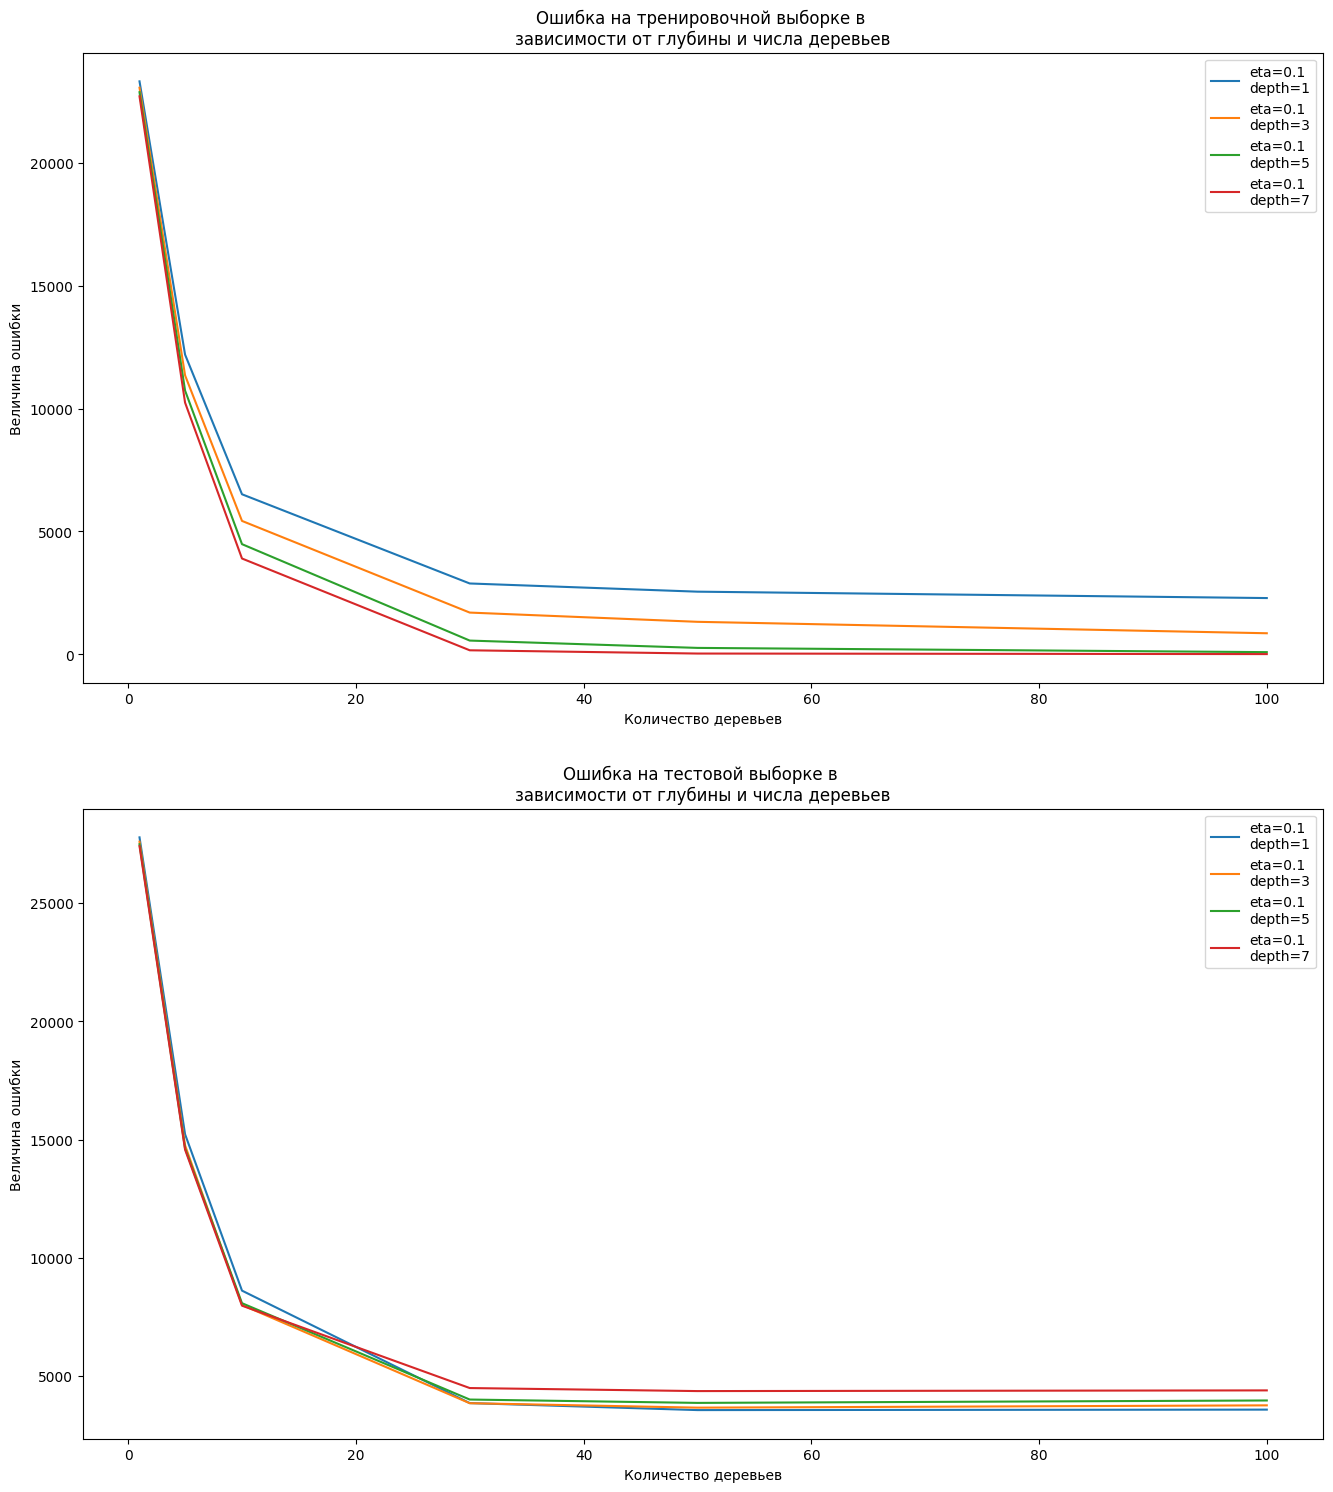

In [19]:
get_plot(tr_err, tst_err, eta, n_trees)

По графикам понятно, что при одинаковых значениях шага обучения рост глубины деревьев ведет к снижению ошибки на трейне, но при этом ошибка на тесте увеличивается, относительно менее глубоких деревьев. При этом, с увеличением числа деревьев с низкой глубиной ошибка на тесте уменьшается